# PARAMETER FITTING PART 2 - OPTIMIZATION

This notebook describes optimization algorithms, ways to search for a minimum value without doing exhaustive search.

# Preliminaries

In [ ]:
IS_COLAB = True

In [ ]:
if IS_COLAB:
    !pip install -q tellurium
    pass

In [ ]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te
import seaborn as sns

# Constants and Helper Functions

In [ ]:
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/vporubsky/network-modeling-summer-school/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, fil

# Optimization Essentials <a class="anchor" id="parameter-fitting-optimization-essentials"></a>

## Definitions

**Optimization** is the term used by mathematicians to find the *best* value of a function.
There are two kinds of "best" - the minimum value and the maximum value.
Actually, the two are equivalent.
This is because finding the maximum value is easily translated into finding the minimum value by searching for the negative of the maximum value.

More formally, we use $f$ to denote a function of many variables.
We denote the $n$-th variable by $x_n$, and so
$f(x_1, \cdots, x_N)$ produces a scalar result given $N$ values.
Here is some useful notation:
* ${\bf x} = (x_1 , \cdots, x_N)$
* $x_n$ is a parameter
* $N$ is the number of parameters to fit
* ${\bf x}^{\star}$ is the vector that minimizes
$f({\bf x})$ for all permitted values of ${\bf x}$

To expand on the last point, in reaction networks, species concentrations
and kinetic constants must be non-negative.

Here's an example of an $f$ in the $x$-$y$ plane:
$f(x, y) = \sqrt{ (x-1)^2 + (y-2)^2)}$.
The input to $f$ is a point in the plane;
the output of $f$ is the distance from that point
to $(1, 2)$.
In this case, $f$ is always non-negative, and so it's
minimum value is 0.

Text(0.5, 1.0, 'Distances from (10, 20).')

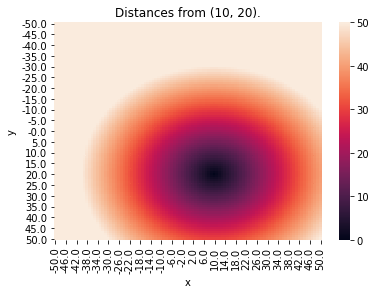

In [ ]:
# Heat map of distances from the point (10, 20)
xstar = 10
ystar = 20
x = np.arange(-50, 50, 0.5)
y = np.arange(-50, 50, 0.5)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()
df = pd.DataFrame({"x": xx.flatten(), "y": yy.flatten()})
df = df.apply(lambda v: np.round(v, 0))
df["distance"] = ((df["x"] - xstar)**2 + (df["y"] - ystar)**2)**0.5
table = pd.pivot_table(df, values='distance', columns=["x"],
                    index=['y'])
ax = sns.heatmap(table, vmin=0, vmax =50)
ax.set_title("Distances from (10, 20).")

In [ ]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

In the following examples, we mostly use $N = 1$ since the visualizations are easier.
But keep in mind that almost always $N$ is much larger than 1 since $N$ is the number of parameters we want to fit.

Many times

## Convex Curves

A convex function of ${\bf x}$ looks like a bowl.
That is, if you repeatedly change ${\bf x}$ so that $f$
gets smaller, you are guaranted to find ${\bf x}^{\star}$.

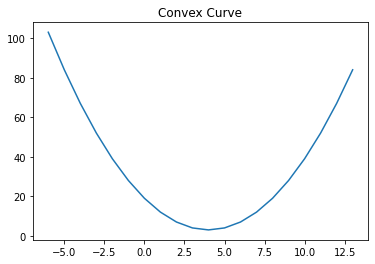

In [ ]:
xv = np.array(range(20))
xv = xv - 6
_ = plt.plot(xv, 3 + (xv - 4)**2 )
_ = plt.title("Convex Curve")

This function is convex. We can readily see that the minimum value of this function occurs at $x^{\star} = 4$.
A convex curve has the very nice property
that its local minimum is also the global minimum.
That is, there are no small valleys where the optimizer might get "stuck".
For this reason, it's easy to find $x^{\star}$ using gradient decent.

## Non-Convex Curves

Unfortunately, convex curves are rare in practice. Much more common is something like the following.

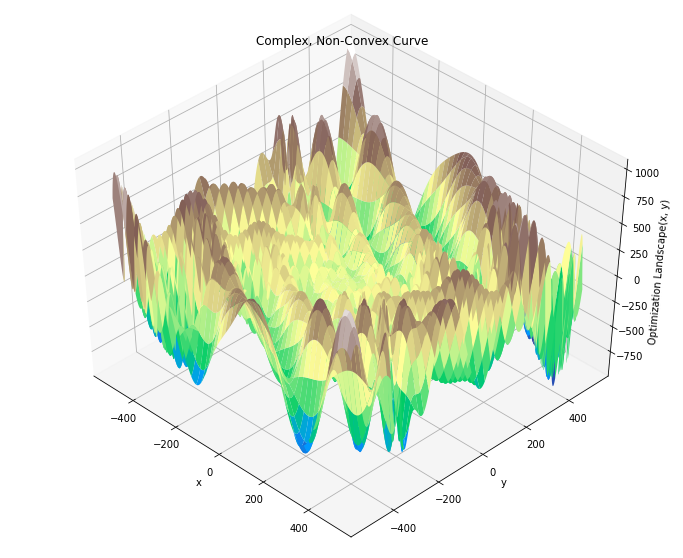

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
          -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Optimization Landscape(x, y)')
ax.set_title("Complex, Non-Convex Curve")
plt.show()

For curves such as these, hueristic methods are needed such as differential evolution, simulated annealing, and random stochastic
gradient descent.

# Programming to find minimum values

Here, we describe how to use the python ``scipy.minimize`` library to find the minimum value of a function.

First, you need to implement $f({\bf x})$.
We implement the distance function in the plane

In [ ]:
def distance(point, center=(10, 20)):
    """
    Calculate the distance from the center.

    Parameters
    ----------
    point: tuple-float
    center: tuple-float

    Returns
    -------
    float
    """
    return sum((np.array(point) - np.array(center))**2)

# TESTS
center = (2, 3)
assert(distance(center, center=center) == 0)

Next, we use the ``LinearConstraint`` class in ``scipy.optimize`` to indicate that we are only intereted in points in the upper right quadrant. This isn't essential for the example we're doing now. But it is very useful later on when we want to ensure that kinetic constants are non-negative. 

The constraints are defined in terms of bounds after a matrix multiplication.
Let ${\bf M}$ be the constraint matrix with dimension $N \times N$, ${\bf x}$ be a solution vector.
Note that $({\bf M})  ({\bf x})$ is also a vector of dimension $N$.
The constraints are that each element in $({\bf M}) ({\bf x})$
must be greater equal to its corresponding element in
${\bf x}^L$ and less than or equal to its corresponding element
in ${\bf x}^U$, where the superscripts $L$, $U$ indicate the lower and upper bound vector.

In the example below,
$ {\bf M} = \begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}$;
${\bf x}^L = [0, 0]$; and
${\bf x}^U = [\infty, \infty]$.
So, the constraints are that $0 \leq x_n \leq \infty$.



In [ ]:
from scipy.optimize import LinearConstraint

eye2Mat = np.identity(2) # Two dimensional identity matrix

constraints = LinearConstraint(eye2Mat, [0, 0], [np.inf, np.inf]),

The code below finds the mimal value for the distance function.
Note that it is sometimes helpful to use the optional keyword argument args to pass additional information to the function being minimized.

In [ ]:
from scipy.optimize import minimize

res = minimize(
    distance,
    constraints=constraints,
    x0=(0, 0),
)

res.x

array([10., 20.])

By default, ``scipy.optimize.minimize`` uses gradient descent.
``minimize`` has a keyword argument ``method`` that provides a way to select other algorithms that are
more appropriate for non-convex curves.
However, for non-convex curves, we recommend using
``scipy.optimize.differential_evolution`` which has a similar (but not identical) interface as ``minimize``.
In particular, note that the bounds are a sequence of min-max pairs for each parameter.

In [ ]:
from scipy.optimize import differential_evolution

bounds = [(0, 100) for _ in range(2)]

res = differential_evolution(
    distance,
    bounds=bounds,
)

res.x

array([10., 20.])

# Exercise

Apply ``scipy.optimize.minimize`` to the ``LINEARY_PATHWAY_MODEL`` to find values of the parameters ``k1, k2, k3, k4`` that minimize the sum of squares of the residuals for ``LINEAR_PATHWAY_DF``.

*Hint*: Create a function that takes as input the values of the parameters of ``LINEAR_PATHWAY_MODEL`` and outputs the sum of squares of the residuals.